### LightGBM

* 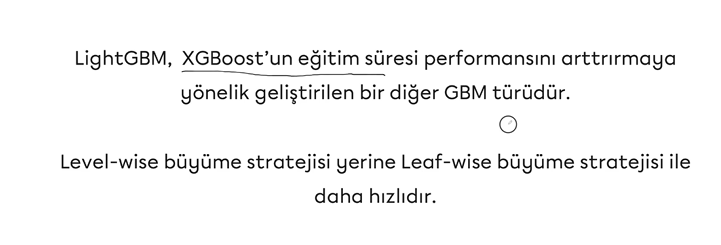

* LightGBM'in başarılı olmasının sebebi split etme yani dallara ayırma bölme büyüme yöntemindeki farklılıktır. xgboost değişkenleri bölme işlemi söz konusu olduğunda bu noktada level-wise yani seviyeye göre büyüme yöntemi izlerken lightgbm bölme noktalara / yapraklara odaklanır. Yani asşında ağğaç yapılarındaki bölme işlemleri düşünüldüğünde xgboost geniş kapsamlı bir ilk arama yaparken lightgbm derinlemesine bir ilk arama yapmaktadır. 

* 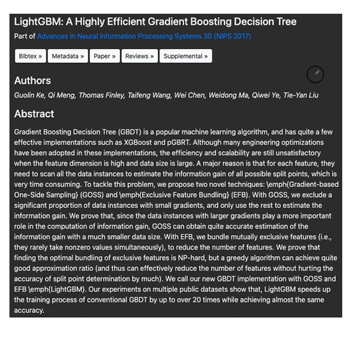

* 

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

df = pd.read_csv("datasets/diabetes.csv")

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [2]:
################################################
# LightGBM
################################################

# Model nesnemizi oluşturuyoruz:
lgbm_model = LGBMClassifier(random_state=17)

# Parametreleri getiriyoruz:
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 17,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [3]:
cv_results = cross_validate(lgbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

# Hiperparametre optimizasyonu öncesinde hatalarımıza bir bakalım:
cv_results['test_accuracy'].mean()

0.7474492827434004

In [4]:
cv_results['test_f1'].mean()

0.624110522144179

In [5]:
cv_results['test_roc_auc'].mean()

0.7990293501048218

In [6]:
# Aramak için bir hiperparametre seti verelim:
# LightGBM XGBoost'tan daha hızlıdır. Bu hızın sebebi LşghtGBM'in yatay ve derinlemesine olan aramasıdır.

lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)


# Final modelimizi kuralım:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [7]:
cv_results['test_accuracy'].mean()

0.7643578643578645

In [8]:
cv_results['test_f1'].mean()

0.6372062920577772

In [9]:
cv_results['test_roc_auc'].mean()

0.8147491264849755

In [10]:
# Hiperparametre yeni değerlerle, yani hiperparametre setini bir miktar değiştirerek tekrar bakalım:
lgbm_params = {"learning_rate": [0.01, 0.02, 0.05, 0.1],
               "n_estimators": [200, 300, 350, 400],
               "colsample_bytree": [0.9, 0.8, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [11]:
cv_results['test_accuracy'].mean()

0.7643833290892115

In [12]:
cv_results['test_f1'].mean()

0.6193071162618689

In [13]:
cv_results['test_roc_auc'].mean()

0.8227931516422082

* DİKKAT : LightGBM'de temel olarak diğer hiperparametreleri belirledikten sonra buradaki tahminci sayısını (n_estimators) 10 binlere kadar denemeliyiz. LightGBM'in en önemli paraöetresi n_estimators'tır. Yine DİKKAT şu anda biz gelişmiş modelleri kullanıyoruz ve elimizde toy birveri seti var. Bazı yöntemler karakteristiğini bu toy veri setlerinde ortaya çıkaramaz. Dolayısıyla aslında daha karmaşık daha yoğun veri setlerinde bu yöntemlerin daha faydalı olabileceğini gözlemleyebiliriz.

In [14]:
# Hiperparametre optimizasyonu sadece n_estimators için.
lgbm_model = LGBMClassifier(random_state=17, colsample_bytree=0.9, learning_rate=0.01)
# colsample_bytree=0.9, learning_rate=0.01 yaparak bu değerleri sabitledik.


# LightGBM kullanıyorsak 5, 10, 15 bin gibi n_estimators değerlerini kesinlikle denemeliyiz!!!
lgbm_params = {"n_estimators": [200, 400, 1000, 5000, 8000, 9000, 10000]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

Fitting 5 folds for each of 7 candidates, totalling 35 fits


In [18]:
lgbm_best_grid.best_params_
# Bu veri seti toy/küçük olduğu için çok büyük bir değer çıkmadı.

{'n_estimators': 200}

In [15]:
cv_results['test_accuracy'].mean()

0.7643833290892115

In [16]:
cv_results['test_f1'].mean()

0.6193071162618689

In [17]:
cv_results['test_roc_auc'].mean()

0.8227931516422082